# Object Detection

Object detection networks are used to detect and localize objects within an image or video. These networks can be used in a wide range of applications, such as autonomous vehicles, surveillance systems, object tracking in videos, human-computer interaction, and advanced driver assistance systems. Object detection has become a crucial part of computer vision and has seen significant improvements in recent years, thanks to deep learning.


In [1]:
# @title # Run the following cell to install the necessary libraries for this practical. { display-mode: "form" }
# @markdown Don't worry about what's in this collapsed cell

import urllib.request
import os
%pip install -q matplotlib
%pip install -q numpy
%pip install -q opencv_python
%pip install -q Pillow
%pip install -q protobuf
%pip install -q pycocotools
%pip install -q torch
%pip install -q torchvision


if not os.path.exists('data'):
    os.mkdir('data')

# Download captions_val2017.json
if not os.path.exists('data/captions_val2017.json'):
    print('Downloading captions_val2017.json...')
    urllib.request.urlretrieve(
        'https://s3-eu-west-1.amazonaws.com/aicore-portal-public-prod-307050600709/practicals_files/6e6fd51e-2bcc-44bf-951e-16f7fc297a47/captions_val2017.json', 'data/captions_val2017.json')

# Download street_scene.jpg
if not os.path.exists('data/street_scene.jpg'):
    print('Downloading street_scene.jpg...')
    urllib.request.urlretrieve(
        'https://s3-eu-west-1.amazonaws.com/aicore-portal-public-prod-307050600709/practicals_files/6e6fd51e-2bcc-44bf-951e-16f7fc297a47/street_scene.jpg', 'data/street_scene.jpg')

# Download instances_val2017.json
if not os.path.exists('data/instances_val2017.json'):
    print('Downloading instances_val2017.json...')
    urllib.request.urlretrieve(
        'https://s3-eu-west-1.amazonaws.com/aicore-portal-public-prod-307050600709/practicals_files/6e6fd51e-2bcc-44bf-951e-16f7fc297a47/instances_val2017.json', 'data/instances_val2017.json')


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from pycocotools.coco import COCO
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms.functional import pil_to_tensor


First, let's set up some transforms we are going to use on our input image. We need to resize the image and convert it to a torch tensor so that we can pass it to the model. We will also need a separate version of the image, which we keep as a PIL image , so that we can use it to plot the bounding boxes of the items detected by the model.


In [4]:
# This transform resizes the image, and converts it to a tensor to use as an input to the model
transform = transforms.Compose([
    transforms.Resize(800),
    transforms.ToTensor(),
])

# This transform just resizes the image, and keeps it as a PIL image. We will use it for plotting the bounding boxes
resize_transform = transforms.Resize(800)


Next, we need to import the image, ensuring it is converted to RGB format, and then use the transforms we composed in the previous code block to transform the image.


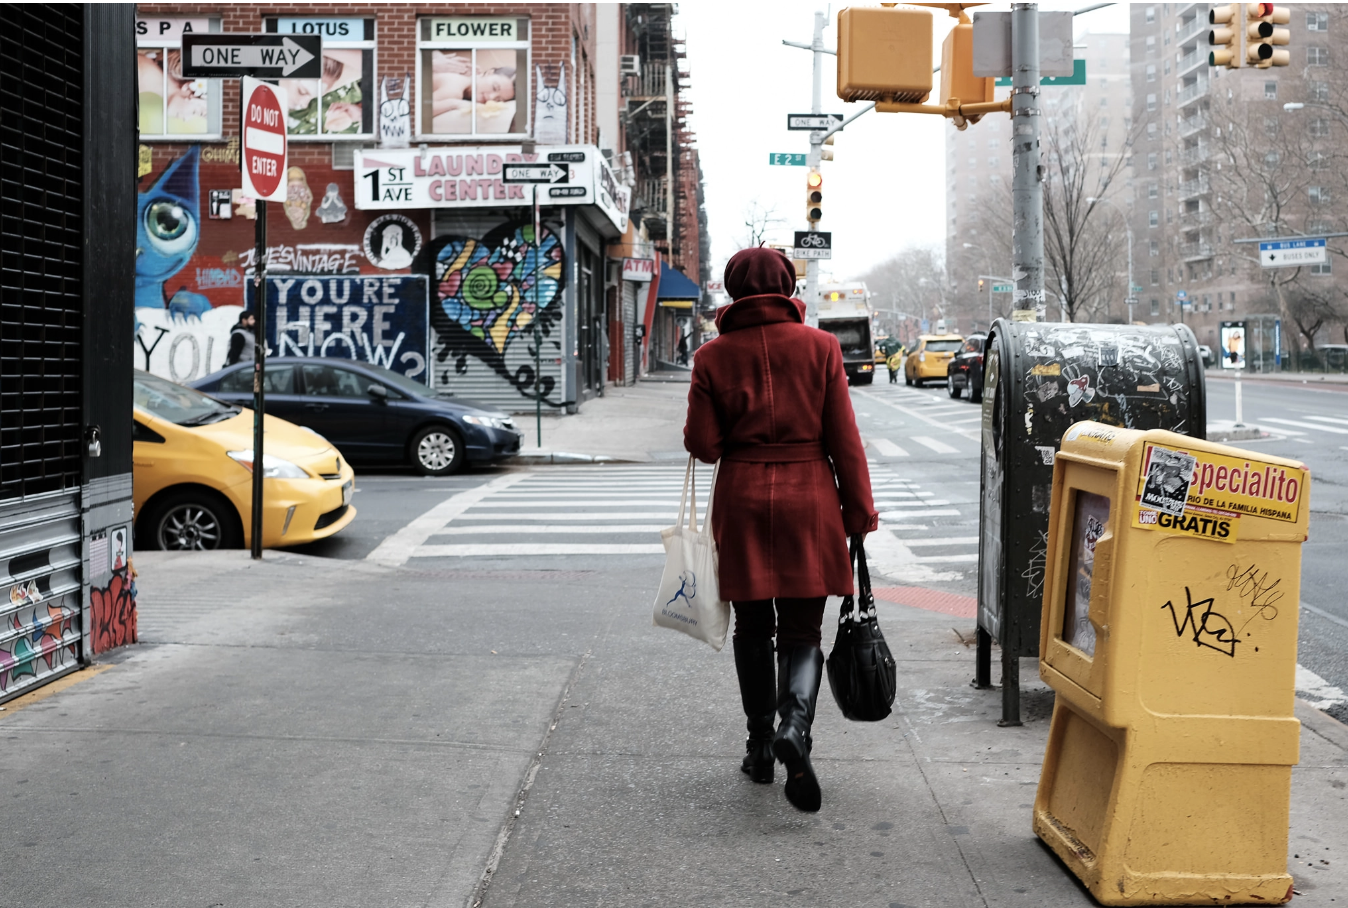

In [6]:
img = Image.open('data/street_scene.jpg').convert('RGB')
image_for_output = pil_to_tensor(img)

image_for_output = resize_transform(image_for_output)
img_tensor = transform(img).unsqueeze(0)

img


Next, we download our pretrained model. We will be using `fasterrcnn_resnet50_fpn`, a popular object detection architecture. It is a two-stage object detector that first generates region proposals and then classifies the regions using a convolutional neural network. The ResNet-50 is a deep residual network that has 50 layers and is used as the backbone network to extract features from the image. The FPN (Feature Pyramidal Network) is used to incorporate features from different scales, making the network more robust to objects of different sizes.

Once the model is downloaded, we set it to evaluation mode using the `eval` command, and pass it our image tensor to predict the object bounding boxes.


In [7]:
object_detection_model = fasterrcnn_resnet50_fpn(
    pretrained=True, 
    progress=False
    )
object_detection_model.eval()

# Run inference
with torch.no_grad():
    street_preds = object_detection_model(img_tensor)


c:\Users\jinch\.conda\envs\ML\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jinch\.conda\envs\ML\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\jinch/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


The model will output a number of boxes around items it thinks are in the image, each with different confidence scores. We can view the confidence scores as follows. Confidence varies between 0 and 1:


In [8]:
street_preds[0]["scores"]


tensor([0.9996, 0.9993, 0.9913, 0.9906, 0.9896, 0.9887, 0.9880, 0.9830, 0.9327,
        0.8959, 0.8748, 0.8566, 0.8321, 0.8039, 0.7866, 0.7104, 0.6457, 0.6371,
        0.6239, 0.6128, 0.5791, 0.5787, 0.5416, 0.4962, 0.4957, 0.4950, 0.4812,
        0.3470, 0.3166, 0.3077, 0.2673, 0.2450, 0.2164, 0.2162, 0.1853, 0.1759,
        0.1666, 0.1559, 0.1422, 0.1419, 0.1386, 0.1367, 0.1315, 0.1294, 0.1273,
        0.1241, 0.1236, 0.1214, 0.1211, 0.1183, 0.1163, 0.1099, 0.1097, 0.0854,
        0.0652, 0.0620, 0.0606, 0.0603, 0.0603, 0.0562, 0.0547, 0.0539, 0.0539,
        0.0531, 0.0507, 0.0504])

We are not too interested in objects it predicted with a low confidence, so let's set a threshold of 0.8 to just select the ones it is pretty certain are there:


In [9]:
# get separate bits, over threshold score
street_preds[0]["boxes"] = street_preds[0]["boxes"][street_preds[0]
                                                    ["scores"] > 0.8]
street_preds[0]["labels"] = street_preds[0]["labels"][street_preds[0]["scores"] > 0.8]
street_preds[0]["scores"] = street_preds[0]["scores"][street_preds[0]["scores"] > 0.8]


As usual for a machine learning model, the labels are currently in integer format, so not very human readable!


In [10]:
street_preds[0]["labels"]


tensor([ 1,  3,  3, 31, 31,  3,  3, 10, 10, 10,  8,  1, 10, 10])

We can import the decoder dictionary, and make the labels human readable. We can also format them for display on the image when we visualise it:


In [12]:
annFile = 'data/instances_val2017.json'
coco = COCO(annFile)

street_labels = coco.loadCats(street_preds[0]["labels"].numpy())
street_annot_labels = ["{}-{:.2f}".format(label["name"], prob) for label, prob in zip(
    street_labels, street_preds[0]["scores"].detach().numpy())]

street_labels


loading annotations into memory...
Done (t=0.84s)
creating index...
index created!


[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'accessory', 'id': 31, 'name': 'handbag'},
 {'supercategory': 'accessory', 'id': 31, 'name': 'handbag'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}]

Finally, we use the `draw_bounding_boxes` method from `torchvision.utils` to plot the bounding boxes on the image, and display it.


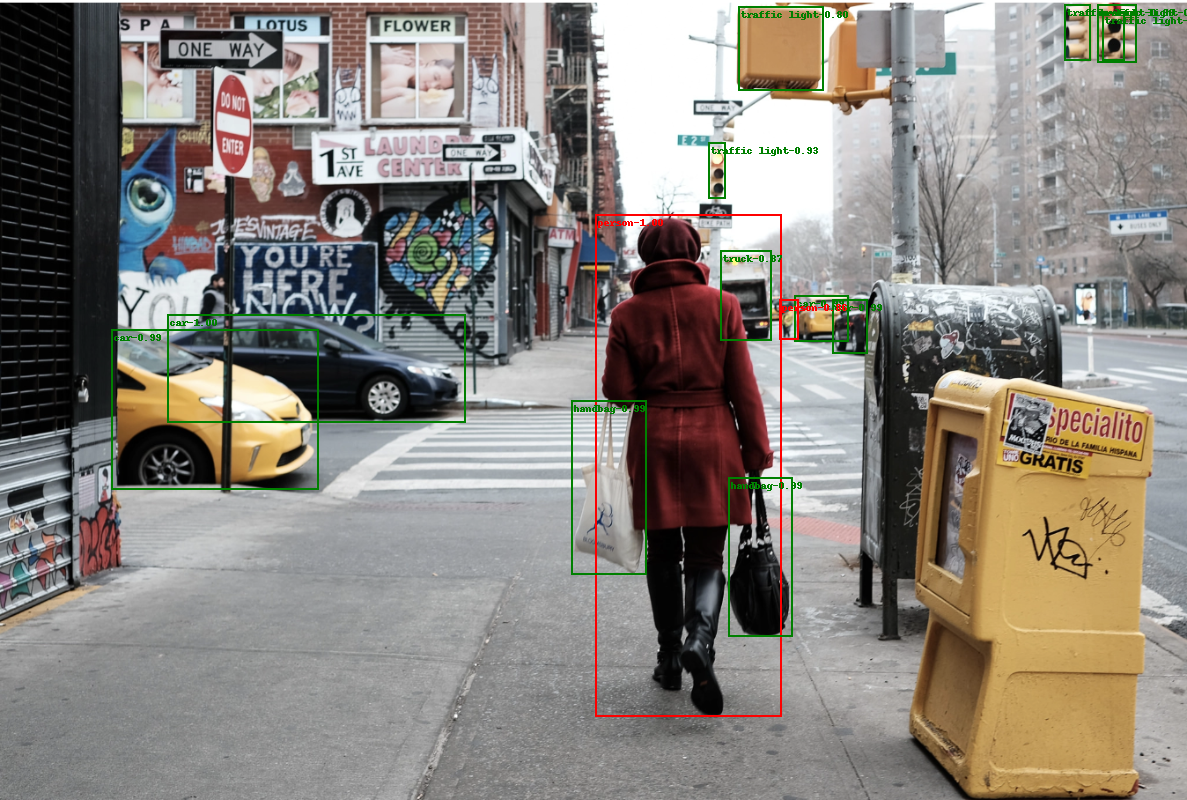

In [13]:
street_output = draw_bounding_boxes(image=image_for_output,
                                    boxes=street_preds[0]["boxes"],
                                    labels=street_annot_labels,
                                    colors=["red" if label["name"] == "person" else "green" for label in street_labels],
                                    width=2
                                    )

to_pil_image(street_output)
